In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation, OPTICS, MeanShift
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from utils import *

In [2]:
# def generate_noisy_data(original_data, n_vectors, scale_factor):
#     """
#     Generate n_vectors of noisy data from the given original_data using a scaling factor.
    
#     Args:
#         original_data (numpy.ndarray): The original data array.
#         n_vectors (int): The number of noisy data vectors to generate.
#         scale_factor (float): The scaling factor for the standard deviation of the noise.
        
#     Returns:
#         numpy.ndarray: A 2D array containing the n_vectors of noisy data,
#                         with each row representing one noisy data vector.
#     """
#     mean = np.mean(original_data)
#     std_dev = np.std(original_data)
    
#     noisy_data_list = []
#     for i in range(n_vectors):
#         scaled_std_dev = std_dev * (1 + i * scale_factor)
#         noise = np.random.normal(mean, scaled_std_dev, original_data.shape)
#         noisy_data = original_data + noise
#         noisy_data_list.append(noisy_data)
    
#     return np.vstack(noisy_data_list)

# # def generate_noisy_data(original_data, n_vectors):
# #     """
# #     Generate n_vectors of noisy data from the given original_data.
    
# #     Args:
# #         original_data (numpy.ndarray): The original data array.
# #         n_vectors (int): The number of noisy data vectors to generate.
        
# #     Returns:
# #         numpy.ndarray: A 2D array containing the n_vectors of noisy data,
# #                         with each row representing one noisy data vector.
# #     """
# #     mean = np.mean(original_data)
# #     std_dev = np.std(original_data)
    
# #     noisy_data_list = []
# #     for _ in range(n_vectors):
# #         noise = np.random.normal(mean, std_dev, original_data.shape)
# #         noisy_data = original_data + noise
# #         noisy_data_list.append(noisy_data)
    
# #     return np.vstack(noisy_data_list)

# def get_dist(data, labels):
#     """
#     Inputs
#         data: input data for clustering
#         labels: labels of clustering output
    
#     Find cluster centers, distances between clusters and distances between data points and centers 
#     Use this to complete calculations AFTER clustering is complete
#     This is based on euclidean metric, NOT the optimization methods or representation sample of the given algorithm
    
#     Outputs:
#         cluster_centers: center of each cluster. expect this as a 1xn array, where n is the number of 
#                 columns in the data set used
#         cluster_distances: distance from the cluster of each cluster to another one. expect this as an cxc matrix,
#                 where c is the number of clusters. the diagonal is always 0 (distance to itself)
#         data_cluster_distances: distance from each sample to the center of each cluster. Expect this as a mxc matrix,
#                 where m is number of samples and c is the number of clusters
#     """

#     # Get the number of clusters (excluding noise)
#     n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

#     # Calculate cluster centers
#     if -1 in labels:
#         cluster = np.array([data[labels == i].mean(axis=0) for i in range(n_clusters)])
#         outlier = np.array([data[labels == -1].mean(axis=0) ])
#         cluster_centers = np.vstack((cluster, outlier))
#     else:
#         cluster_centers = np.array([data[labels == i].mean(axis=0) for i in range(n_clusters)])

# #     print("Cluster Centers:")
# #     print(cluster_centers)

#     # Compute the pairwise distances between cluster centers
#     cluster_distances = cdist(cluster_centers, cluster_centers, metric='euclidean')
#     # Print the distances between cluster centers
#     print("Distances between cluster centers:")
#     print(cluster_distances)

#     # Compute the distances between each data point and cluster centers
#     data_cluster_distances = cdist(data, cluster_centers, metric='euclidean')

#     # Print the distances between each data point and cluster centers
#     print("\nDistances between data points and cluster centers:")
#     for i, distances in enumerate(data_cluster_distances):
#         print(f"Data point {i}: {distances}")
        
#     return 

# # # Calculate cluster centers for AgglomerativeClustering
# # cluster_centers = np.array([data_scaled[labels == i].mean(axis=0) for i in range(agg.n_clusters_)])

# # print("\nAgglomerativeClustering Cluster Centers:")
# # print(cluster_centers)

# # # Compute the pairwise distances between cluster centers
# # cluster_distances = cdist(cluster_centers, cluster_centers, metric='euclidean')
# # # Print the distances between cluster centers
# # print("Distances between cluster centers:")
# # print(cluster_distances)

# # # Compute the distances between each data point and cluster centers
# # data_cluster_distances = cdist(data_scaled, cluster_centers, metric='euclidean')

# # # Print the distances between each data point and cluster centers
# # print("\nDistances between data points and cluster centers:")
# # for i, distances in enumerate(data_cluster_distances):
# #     print(f"Data point {i}: {distances}")

In [59]:
# Load the dataset
biomass_data = pd.read_csv('site_data.csv')

# Transpose the DataFrame to have products as rows and locations as columns
data_transposed = biomass_data.set_index(['dataset', 'site_name', 'site_id', 'X', 'Y']).T

# Remove non-numeric rows
data_transposed_numeric = data_transposed.select_dtypes(include=[np.number])

# Replace 'NA' with NaN
data_transposed_numeric = data_transposed_numeric.replace('NA', np.nan)

# Drop rows with all NaN values
data_transposed_numeric = data_transposed_numeric.dropna(axis=1, how='all')

# Impute missing values with column mean
imputer = SimpleImputer(strategy='mean')
# Impute missing values with ROW mean (must use transposed df and axis=1 for rows)
data_imputed = data_transposed_numeric.T.fillna(data_transposed_numeric.mean(axis=1)).T

data_imputed

dataset                    NEON                                             \
site_name        Harvard Forest Smithsonian Conservation Biology Institute   
site_id                    HARV                                       SCBI   
X                   -72.172660                                 -78.139500    
Y                     42.536900                                  38.892920   
ESA CCI               21.046901                                  21.046901   
Chopping et al.       18.783055                                  18.783055   
GEDI L4B             164.080719                                 334.279755   
Liu et al.            37.921211                                 115.212837   
LT-GNN                31.403246                                  31.403246   
Menlove & Healey     114.922806                                 106.782768   
Xu et al.             69.325028                                  69.325028   

dataset                                                         \
site_name        Ordway-Swisher Biological Station      UNDERC   
site_id                                       OSBS        UNDE   
X                                      -81.993430  -89.537250    
Y                                        29.689270   46.233880   
ESA CCI                                  21.046901   21.046901   
Chopping et al.                          18.783055   18.783055   
GEDI L4B                                 63.379155  155.069643   
Liu et al.                               69.890287  139.331772   
LT-GNN                                   31.403246   31.403246   
Menlove & Healey                         42.734001   91.699257   
Xu et al.                                69.325028   69.325028   

dataset                                                        \
site_name        Konza Prairie Biological Station   Oak Ridge   
site_id                                      KONZ        ORNL   
X                                     -96.563090  -84.282600    
Y                                       39.100770   35.964120   
ESA CCI                                 21.046901   21.046901   
Chopping et al.                         18.783055   18.783055   
GEDI L4B                                 7.477551  162.482702   
Liu et al.                              10.838812   91.845345   
LT-GNN                                  31.403246   31.403246   
Menlove & Healey                        10.135107  115.705890   
Xu et al.                               69.325028   69.325028   

dataset                                                 \
site_name        Talladega National Forest   Woodworth   
site_id                               TALL        WOOD   
X                              -87.393270  -99.241356    
Y                                32.950460   47.128228   
ESA CCI                          21.046901   21.046901   
Chopping et al.                  18.783055   18.783055   
GEDI L4B                        228.355491    4.161302   
Liu et al.                       85.784576    9.719982   
LT-GNN                           31.403246   31.403246   
Menlove & Healey                125.903267    0.000000   
Xu et al.                        69.325028   69.325028   

dataset                                                                    \
site_name        Central Plains Experimental Range LBJ National Grassland   
site_id                                       CPER                   CLBJ   
X                                      -104.745602            -97.570000    
Y                                        40.815534              33.401230   
ESA CCI                                  21.046901              21.046901   
Chopping et al.                           0.000000              18.783055   
GEDI L4B                                  1.268689              17.868778   
Liu et al.                                9.621728              11.764260   
LT-GNN                                   31.403246              31.403246   
Menlove & Healey      

In [60]:
biomass_data

,dataset,site_name,site_id,X,Y,ESA CCI,Chopping et al.,GEDI L4B,Liu et al.,LT-GNN,Menlove & Healey,Xu et al.
0,NEON,Harvard Forest,HARV,-72.17266,42.53690,NaN,NaN,164.080719,37.921211,NaN,114.922806,NaN
1,NEON,Smithsonian Conservation Biology Institute,SCBI,-78.13950,38.89292,NaN,NaN,334.279755,115.212837,NaN,106.782768,NaN
2,NEON,Ordway-Swisher Biological Station,OSBS,-81.99343,29.68927,NaN,NaN,63.379155,69.890287,NaN,42.734001,NaN
3,NEON,Guanica Forest,GUAN,-66.86870,17.96955,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NEON,UNDERC,UNDE,-89.53725,46.23388,NaN,NaN,155.069643,139.331772,NaN,91.699257,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
502,Ameriflux,NEON University of Notre Dame Environmental Re...,US-xUN,-89.53730,46.23390,NaN,NaN,155.035292,139.331772,NaN,91.699257,NaN
503,Ameriflux,NEON Woodworth (WOOD),US-xWD,-99.24140,47.12820,NaN,NaN,4.150213,9.719900,NaN,0.000000,NaN
504,Ameriflux,NEON Wind River Experimental Forest (WREF),US-xWR,-121.95190,45.82050,244.415145,NaN,357.726868,194.783264,NaN,320.595123,819.682068
505,Ameriflux,NEON Yellowstone Northern Range (Frog Rock) (Y...,US-xYE,-110.53910,44.95350,7.986143,NaN,37.207724,59.854660,NaN,36.563770,79.867683


In [61]:
df=data_imputed
# Specify the mean and standard deviation of the Gaussian noise
mean = np.mean(df.loc['Liu et al.'])
std_dev = np.std(df.loc['Liu et al.'])
var = np.var(df.loc['Liu et al.'])

# # Generate random noise from a Gaussian distribution
# noise = np.random.normal(mean, std_dev, df.loc['Liu et al.'].shape)
# # Add the noise to the dataset
# noisy_data_1 = df.loc['Liu et al.'] + noise   

In [62]:
# Generate 10 vectors of noisy data from the first dataset
noisy_data_1 = generate_noisy_data(df.loc['Liu et al.'], 10, 0)

# Generate 10 vectors of noisy data from the second dataset
noisy_data_2 = generate_noisy_data(df.loc['GEDI L4B'], 10, 0)

# Combine the noisy data vectors from both datasets
Liu_Gedi = np.vstack((noisy_data_1, noisy_data_2))
Liu_Gedi

array([[119.40701622, 143.73462802, 173.14641846, ..., 254.35531859,
        163.8795319 ,  44.97016177],
       [ 63.17439269, 178.00295486,  67.98087342, ..., 218.60210812,
        130.30882247,  58.92612371],
       [ 92.99153808, 167.58741179, 153.12408642, ..., 243.61376176,
        136.36570813,  84.07431001],
       ...,
       [138.85660007, 396.37897653, 102.17736822, ..., 457.41770178,
        101.87446003, 143.74890256],
       [233.07660863, 375.13298186, 184.34013199, ..., 549.98150218,
        126.36927558, 121.38688709],
       [178.94650014, 398.96564696,  63.4376895 , ..., 429.60090387,
        141.95482108,  95.54905152]])

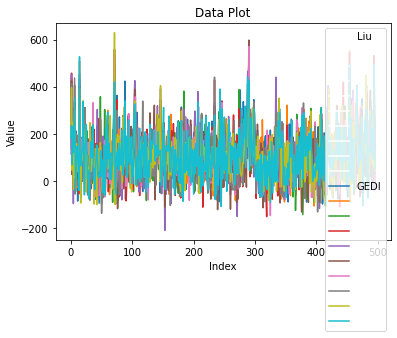

In [7]:
# Plot first 10 rows in red
for i in range(10):
    plt.plot(Liu_Gedi[i], color='w')

# Plot next 10 rows in blue
for i in range(10, 20):
    plt.plot(Liu_Gedi[i])

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Data Plot')
plt.legend(['Liu','','','','','','','','','', 'GEDI','','','','','','','','',''])

plt.show()

In [8]:
# Print summary statistics
print("Summary Statistics: Liu")
print("Mean:", np.mean(Liu_Gedi[1:10]))
print("Median:", np.median(Liu_Gedi[1:10]))
print("Standard Deviation:", np.std(Liu_Gedi[1:10]))
print("Variance:", np.var(Liu_Gedi[1:10]))
print("Minimum:", np.min(Liu_Gedi[1:10]))
print("Maximum:", np.max(Liu_Gedi[1:10]))
print("Range:", np.max(Liu_Gedi[1:10])-np.min(Liu_Gedi[1:10]))
print()

Summary Statistics: Liu
Mean: 89.79311687075895
Median: 84.22784863084067
Standard Deviation: 59.97335142016961
Variance: 3596.80288056716
Minimum: -108.43412042128631
Maximum: 352.85254021518807
Range: 461.2866606364744



In [9]:
G=Liu_Gedi[10:20]
# Print summary statistics
print("Summary Statistics: Gedi")
print("Mean:", np.mean(G))
print("Median:", np.median(G))
print("Standard Deviation:", np.std(G))
print("Variance:", np.var(G))
print("Minimum:", np.min(G))
print("Maximum:", np.max(G))
print("Range:", np.max(G)-np.min(G))
print()

Summary Statistics: Gedi
Mean: 109.19595581103
Median: 98.66633659496387
Standard Deviation: 100.4379311488643
Variance: 10087.778013464003
Minimum: -208.1766542715923
Maximum: 630.1511655482614
Range: 838.3278198198536



In [10]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(Liu_Gedi)

agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters = agg.fit_predict(data_scaled)
labels = agg.labels_
print("Cluster labels:", clusters)

get_dist(data_scaled, labels)

Cluster labels: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Distances between cluster centers:
[[ 0.         16.60932703]
 [16.60932703  0.        ]]

Distances between data points and cluster centers:
Data point 0: [23.06663918 15.57797182]
Data point 1: [23.03563292 15.27427659]
Data point 2: [23.51317438 15.68439121]
Data point 3: [22.70504354 15.91988973]
Data point 4: [21.64571777 14.8720971 ]
Data point 5: [23.06159558 15.68516679]
Data point 6: [21.41239843 15.19751506]
Data point 7: [22.20085483 14.76735458]
Data point 8: [23.08951686 15.46465853]
Data point 9: [23.0781734 16.0951457]
Data point 10: [26.57804237 30.74127484]
Data point 11: [24.07857033 29.07629704]
Data point 12: [24.3650985  29.53048582]
Data point 13: [24.2735086  29.22744786]
Data point 14: [24.11867397 30.18355297]
Data point 15: [25.64112304 31.00287664]
Data point 16: [24.78249406 29.62038451]
Data point 17: [25.51104095 29.95843347]
Data point 18: [23.94594423 28.84657389]
Data point 19: [24.98353405 30.55

In [11]:
# DBSCAN clustering
dbscan = DBSCAN(eps=22, min_samples=2)  # Adjust the parameters as needed
clusters = dbscan.fit_predict(data_scaled)
if -1 in clusters:
    print("noise found during clustering, contained in cluster -1")
labels = dbscan.labels_
print("DBSCAN Cluster labels:", clusters)

get_dist(data_scaled, labels)
#at eps=23, this is the same as OPTICS?

noise found during clustering, contained in cluster -1
DBSCAN Cluster labels: [-1  0 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Distances between cluster centers:
[[ 0.         15.62296361]
 [15.62296361  0.        ]]

Distances between data points and cluster centers:
Data point 0: [20.9624271  18.14842151]
Data point 1: [10.83450695 18.95118858]
Data point 2: [20.11184612 18.61855724]
Data point 3: [20.80699917 18.07967912]
Data point 4: [20.0215724  16.92372897]
Data point 5: [20.65380422 18.23526358]
Data point 6: [20.31160461 16.88098866]
Data point 7: [19.87096654 17.28809225]
Data point 8: [10.83450695 19.07300493]
Data point 9: [20.78049648 18.42837459]
Data point 10: [32.86187086 27.29913298]
Data point 11: [31.45230361 25.09269598]
Data point 12: [32.43844451 25.39965078]
Data point 13: [31.27645921 25.31800561]
Data point 14: [32.93856841 25.62297615]
Data point 15: [33.05139303 26.93784637]
Data point 16: [31.29226031 25.83814004]
Data point 17: [32.71015938 26.

In [12]:
#OPTICS clustering
optics = OPTICS(min_samples=2)
clusters = optics.fit_predict(data_scaled)
labels = optics.labels_
print("OPTICS Cluster labels:", clusters)

get_dist(data_scaled, labels)


OPTICS Cluster labels: [ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Distances between cluster centers:
[[ 0.         16.60932703]
 [16.60932703  0.        ]]

Distances between data points and cluster centers:
Data point 0: [15.57797182 23.06663918]
Data point 1: [15.27427659 23.03563292]
Data point 2: [15.68439121 23.51317438]
Data point 3: [15.91988973 22.70504354]
Data point 4: [14.8720971  21.64571777]
Data point 5: [15.68516679 23.06159558]
Data point 6: [15.19751506 21.41239843]
Data point 7: [14.76735458 22.20085483]
Data point 8: [15.46465853 23.08951686]
Data point 9: [16.0951457 23.0781734]
Data point 10: [30.74127484 26.57804237]
Data point 11: [29.07629704 24.07857033]
Data point 12: [29.53048582 24.3650985 ]
Data point 13: [29.22744786 24.2735086 ]
Data point 14: [30.18355297 24.11867397]
Data point 15: [31.00287664 25.64112304]
Data point 16: [29.62038451 24.78249406]
Data point 17: [29.95843347 25.51104095]
Data point 18: [28.84657389 23.94594423]
Data p

In [63]:
# Add cluster labels to the transposed DataFrame, for 1)
products = ['Liu et al.', 'Liu et al.', 'Liu et al.', 'Liu et al.', 'Liu et al.', 'Liu et al.', 'Liu et al.', 'Liu et al.', 'Liu et al.', 'Liu et al.', 'GEDI L4B', 'GEDI L4B', 'GEDI L4B', 'GEDI L4B', 'GEDI L4B', 'GEDI L4B', 'GEDI L4B', 'GEDI L4B', 'GEDI L4B', 'GEDI L4B']
Liu_Gedi = pd.DataFrame(Liu_Gedi,index=products)  # Convert to DataFrame if it's not already
Liu_Gedi

,0,1,2,3,4,5,6,7,8,9,...,487,488,489,490,491,492,493,494,495,496
Liu et al.,119.407016,143.734628,173.146418,175.881317,106.144971,122.211131,158.231800,99.842471,80.902218,-31.460812,...,226.489469,120.823909,88.554269,137.514479,109.551648,183.923514,89.280280,254.355319,163.879532,44.970162
Liu et al.,63.174393,178.002955,67.980873,225.668090,32.522337,150.558131,183.655149,69.027067,120.064272,60.170369,...,226.581799,150.310175,72.052044,85.114160,51.366840,142.495317,124.016101,218.602108,130.308822,58.926124
Liu et al.,92.991538,167.587412,153.124086,244.341439,15.700697,105.487568,138.017510,84.632984,46.657129,13.329593,...,159.331550,112.831255,153.228585,115.493618,85.321485,131.231531,71.113811,243.613762,136.365708,84.074310
Liu et al.,87.711256,168.130484,114.987424,182.635519,-8.050552,148.377937,29.215505,80.611985,80.288138,48.664867,...,254.579202,148.187079,62.657495,103.735804,98.669659,148.652090,33.584523,240.073495,62.492466,7.666234
Liu et al.,44.099803,117.356291,91.089237,174.739317,17.277660,193.654434,168.908574,81.776512,-0.495746,139.099112,...,126.319848,129.069738,128.712026,75.584216,85.087793,192.189542,50.156501,286.235963,81.680073,88.450556
Liu et al.,53.684490,171.182140,117.171419,235.465164,94.043304,132.645876,130.158249,96.737865,57.669626,108.160887,...,102.447586,51.865502,31.657142,272.461024,114.652275,150.030981,71.372702,245.758993,147.540421,65.243181
Liu et al.,55.349023,119.920800,92.109852,146.909624,56.749964,129.696866,126.260547,98.211202,65.852968,71.218572,...,146.250087,95.314087,151.595887,32.101543,30.568903,274.284434,24.237525,144.203077,88.130713,112.004100
Liu et al.,98.280260,177.921502,132.090815,176.906890,13.964294,194.257689,186.079289,106.077115,39.893875,56.898780,...,157.603083,151.004421,70.379701,31.561696,57.632459,115.649972,33.996441,212.471228,124.716790,22.103054
Liu et al.,56.586884,111.872709,16.139821,217.803999,60.348513,159.367094,92.744136,-20.449669,64.695338,33.923292,...,148.726470,63.911225,150.562373,137.223349,41.926781,154.454907,-32.699370,318.691501,100.360047,70.544759
Liu et al.,88.009395,215.367731,83.588694,172.331361,14.007479,117.631547,82.173218,86.154280,4.463023,-46.937606,...,220.972320,124.895766,38.345640,45.506032,71.221214,233.422307,57.535120,244.335489,103.641383,-10.329863


In [66]:
Liu_Gedi.loc[:,'cluster'] = clusters
Liu_Gedi

,0,1,2,3,4,5,6,7,8,9,...,488,489,490,491,492,493,494,495,496,cluster
Liu et al.,119.407016,143.734628,173.146418,175.881317,106.144971,122.211131,158.231800,99.842471,80.902218,-31.460812,...,120.823909,88.554269,137.514479,109.551648,183.923514,89.280280,254.355319,163.879532,44.970162,0
Liu et al.,63.174393,178.002955,67.980873,225.668090,32.522337,150.558131,183.655149,69.027067,120.064272,60.170369,...,150.310175,72.052044,85.114160,51.366840,142.495317,124.016101,218.602108,130.308822,58.926124,0
Liu et al.,92.991538,167.587412,153.124086,244.341439,15.700697,105.487568,138.017510,84.632984,46.657129,13.329593,...,112.831255,153.228585,115.493618,85.321485,131.231531,71.113811,243.613762,136.365708,84.074310,0
Liu et al.,87.711256,168.130484,114.987424,182.635519,-8.050552,148.377937,29.215505,80.611985,80.288138,48.664867,...,148.187079,62.657495,103.735804,98.669659,148.652090,33.584523,240.073495,62.492466,7.666234,0
Liu et al.,44.099803,117.356291,91.089237,174.739317,17.277660,193.654434,168.908574,81.776512,-0.495746,139.099112,...,129.069738,128.712026,75.584216,85.087793,192.189542,50.156501,286.235963,81.680073,88.450556,0
Liu et al.,53.684490,171.182140,117.171419,235.465164,94.043304,132.645876,130.158249,96.737865,57.669626,108.160887,...,51.865502,31.657142,272.461024,114.652275,150.030981,71.372702,245.758993,147.540421,65.243181,0
Liu et al.,55.349023,119.920800,92.109852,146.909624,56.749964,129.696866,126.260547,98.211202,65.852968,71.218572,...,95.314087,151.595887,32.101543,30.568903,274.284434,24.237525,144.203077,88.130713,112.004100,0
Liu et al.,98.280260,177.921502,132.090815,176.906890,13.964294,194.257689,186.079289,106.077115,39.893875,56.898780,...,151.004421,70.379701,31.561696,57.632459,115.649972,33.996441,212.471228,124.716790,22.103054,0
Liu et al.,56.586884,111.872709,16.139821,217.803999,60.348513,159.367094,92.744136,-20.449669,64.695338,33.923292,...,63.911225,150.562373,137.223349,41.926781,154.454907,-32.699370,318.691501,100.360047,70.544759,0
Liu et al.,88.009395,215.367731,83.588694,172.331361,14.007479,117.631547,82.173218,86.154280,4.463023,-46.937606,...,124.895766,38.345640,45.506032,71.221214,233.422307,57.535120,244.335489,103.641383,-10.329863,0


In [67]:
# Transpose the data back to the original format
# biomass_data_clustered = Liu_Gedi.reset_index()
# biomass_data_clustered
corr_matrix=plot_heat_by_clus(Liu_Gedi,products)

biomass_data_clustered has more columns than rows, clustering occured on products


KeyError: 'index'

In [14]:
#MeanShift clustering
#MeanShift is based on centroids. GEDI likely has too much variance for MeanShift to be effective.

meanshift = MeanShift()
clusters = meanshift.fit_predict(data_scaled)
labels= meanshift.labels_
print("Cluster labels:", clusters)

get_dist(data_scaled, labels)

Cluster labels: [ 0  0  0  0  0  0  0  0  0  0  5  8  1  3  2  9 10  4  6  7]
Distances between cluster centers:
[[ 0.         29.53048582 30.18355297 29.22744786 29.95843347 30.74127484
  28.84657389 30.55325417 29.07629704 31.00287664 29.62038451]
 [29.53048582  0.         36.20651425 36.83648045 36.67747531 37.98843241
  35.06377265 36.15292246 36.60304382 37.24337049 37.25332025]
 [30.18355297 36.20651425  0.         34.96523449 37.60299253 37.87761069
  35.83365458 35.99063091 35.66802711 37.56323883 36.64866191]
 [29.22744786 36.83648045 34.96523449  0.         36.6667131  38.34444668
  36.78069057 37.65850489 34.66487543 36.75631828 36.67301909]
 [29.95843347 36.67747531 37.60299253 36.6667131   0.         38.80929604
  37.20771737 38.3116492  37.30250527 38.0007926  37.16646225]
 [30.74127484 37.98843241 37.87761069 38.34444668 38.80929604  0.
  38.46378963 37.81604346 38.89132984 38.58002215 38.33979942]
 [28.84657389 35.06377265 35.83365458 36.78069057 37.20771737 38.46378963

# Clustering with features

In [15]:
products = ['Liu et al.', 'GEDI L4B']
feature_cols = ['multispec', 'lidar', 'micro','field','ML']
multispec=np.array([1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0])
lidar=np.array([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1])
micro=np.array([1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0])
field=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
ML=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

matrix=np.column_stack((multispec,lidar,micro,field,ML))
feature_df = pd.DataFrame(matrix)
feature_df.columns = ['multispec', 'lidar', 'micro', 'field', 'ML']
print(feature_df)


Liu_Gedi_df = pd.DataFrame(Liu_Gedi)
Liu_Gedi_feat= pd.concat([Liu_Gedi_df, feature_df], axis=1)
print(Liu_Gedi_feat)

scaler = StandardScaler()
data_scaled_feat = scaler.fit_transform(Liu_Gedi_feat)

    multispec  lidar  micro  field  ML
0           1      0      1      0   0
1           1      0      1      0   0
2           1      0      1      0   0
3           1      0      1      0   0
4           1      0      1      0   0
5           1      0      1      0   0
6           1      0      1      0   0
7           1      0      1      0   0
8           1      0      1      0   0
9           1      0      1      0   0
10          0      1      0      0   0
11          0      1      0      0   0
12          0      1      0      0   0
13          0      1      0      0   0
14          0      1      0      0   0
15          0      1      0      0   0
16          0      1      0      0   0
17          0      1      0      0   0
18          0      1      0      0   0
19          0      1      0      0   0
             0           1           2           3           4           5  \
0    33.759518  174.562519  169.577435  186.443709   78.610665  193.576167   
1   142.903511  167.05965

In [16]:
#OPTICS clustering

optics = OPTICS(min_samples=2)
clusters_ft = optics.fit_predict(data_scaled_feat)
labels_ft = optics.labels_
print("OPTICS Cluster labels:", clusters_ft)

get_dist(data_scaled_feat, labels_ft)

OPTICS Cluster labels: [ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Distances between cluster centers:
[[ 0.         17.08419575]
 [17.08419575  0.        ]]

Distances between data points and cluster centers:
Data point 0: [15.57797182 23.41089155]
Data point 1: [15.27427659 23.38034183]
Data point 2: [15.68439121 23.85098257]
Data point 3: [15.91988973 23.05469588]
Data point 4: [14.8720971  22.01220339]
Data point 5: [15.68516679 23.40592212]
Data point 6: [15.19751506 21.78280989]
Data point 7: [14.76735458 22.55832341]
Data point 8: [15.46465853 23.43343314]
Data point 9: [16.0951457  23.42225624]
Data point 10: [31.00041901 26.57804237]
Data point 11: [29.35014565 24.07857033]
Data point 12: [29.80016095 24.3650985 ]
Data point 13: [29.49989337 24.2735086 ]
Data point 14: [30.44744439 24.11867397]
Data point 15: [31.25985221 25.64112304]
Data point 16: [29.88924855 24.78249406]
Data point 17: [30.2242905  25.51104095]
Data point 18: [29.12258273 23.94594423]
Data

In [17]:
# DBSCAN clustering
dbscan = DBSCAN(eps=22, min_samples=2)  # Adjust the parameters as needed
clusters_ft = dbscan.fit_predict(data_scaled_feat)
if -1 in clusters_ft:
    print("noise found during clustering, contained in cluster -1")
labels_ft = dbscan.labels_
print("DBSCAN Cluster labels:", clusters)

get_dist(data_scaled_feat, labels_ft)

noise found during clustering, contained in cluster -1
DBSCAN Cluster labels: [ 0  0  0  0  0  0  0  0  0  0  5  8  1  3  2  9 10  4  6  7]
Distances between cluster centers:
[[ 0.         15.78021748]
 [15.78021748  0.        ]]

Distances between data points and cluster centers:
Data point 0: [20.9624271 18.2839677]
Data point 1: [10.83450695 19.081033  ]
Data point 2: [20.11184612 18.75070519]
Data point 3: [20.80699917 18.21573684]
Data point 4: [20.0215724  17.06900331]
Data point 5: [20.65380422 18.37016901]
Data point 6: [20.31160461 17.02662767]
Data point 7: [19.87096654 17.43033004]
Data point 8: [10.83450695 19.20202564]
Data point 9: [20.78049648 18.56187656]
Data point 10: [33.10441898 27.35695808]
Data point 11: [31.70563676 25.15559352]
Data point 12: [32.68413502 25.46179007]
Data point 13: [31.53120519 25.3803448 ]
Data point 14: [33.18055589 25.68457515]
Data point 15: [33.29256045 26.99644534]
Data point 16: [31.54687869 25.8992273 ]
Data point 17: [32.95382416 26.31

In [18]:
#MeanShift clustering

meanshift = MeanShift()
clusters_ft = meanshift.fit_predict(data_scaled)
labels_ft = meanshift.labels_
print("Cluster labels:", clusters_ft)

get_dist(data_scaled_feat, labels_ft)

Cluster labels: [ 0  0  0  0  0  0  0  0  0  0  5  8  1  3  2  9 10  4  6  7]
Distances between cluster centers:
[[ 0.         29.80016095 30.44744439 29.49989337 30.2242905  31.00041901
  29.12258273 30.81397963 29.35014565 31.25985221 29.88924855]
 [29.80016095  0.         36.20651425 36.83648045 36.67747531 37.98843241
  35.06377265 36.15292246 36.60304382 37.24337049 37.25332025]
 [30.44744439 36.20651425  0.         34.96523449 37.60299253 37.87761069
  35.83365458 35.99063091 35.66802711 37.56323883 36.64866191]
 [29.49989337 36.83648045 34.96523449  0.         36.6667131  38.34444668
  36.78069057 37.65850489 34.66487543 36.75631828 36.67301909]
 [30.2242905  36.67747531 37.60299253 36.6667131   0.         38.80929604
  37.20771737 38.3116492  37.30250527 38.0007926  37.16646225]
 [31.00041901 37.98843241 37.87761069 38.34444668 38.80929604  0.
  38.46378963 37.81604346 38.89132984 38.58002215 38.33979942]
 [29.12258273 35.06377265 35.83365458 36.78069057 37.20771737 38.46378963

In [19]:
#OPTICS clustering just features
scaler = StandardScaler()
data_scaled_onlyfeat = scaler.fit_transform(feature_df)

optics = OPTICS(min_samples=2)
clusters_ft = optics.fit_predict(data_scaled_onlyfeat )
labels_ft = optics.labels_
print("OPTICS Cluster labels:", clusters_ft)

get_dist(data_scaled_onlyfeat, labels_ft)

OPTICS Cluster labels: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Distances between cluster centers:
[[0.         3.46410162]
 [3.46410162 0.        ]]

Distances between data points and cluster centers:
Data point 0: [0.         3.46410162]
Data point 1: [0.         3.46410162]
Data point 2: [0.         3.46410162]
Data point 3: [0.         3.46410162]
Data point 4: [0.         3.46410162]
Data point 5: [0.         3.46410162]
Data point 6: [0.         3.46410162]
Data point 7: [0.         3.46410162]
Data point 8: [0.         3.46410162]
Data point 9: [0.         3.46410162]
Data point 10: [3.46410162 0.        ]
Data point 11: [3.46410162 0.        ]
Data point 12: [3.46410162 0.        ]
Data point 13: [3.46410162 0.        ]
Data point 14: [3.46410162 0.        ]
Data point 15: [3.46410162 0.        ]
Data point 16: [3.46410162 0.        ]
Data point 17: [3.46410162 0.        ]
Data point 18: [3.46410162 0.        ]
Data point 19: [3.46410162 0.        ]


C:\Users\aizax\anaconda3\lib\site-packages\sklearn\cluster\_optics.py:803: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [20]:
#MeanShift clustering just features

meanshift = MeanShift()
clusters_ft = meanshift.fit_predict(data_scaled_onlyfeat )
labels_ft = meanshift.labels_
print("MeanShift Cluster labels:", clusters_ft)

get_dist(data_scaled_onlyfeat, labels_ft)

MeanShift Cluster labels: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Distances between cluster centers:
[[0.         3.46410162]
 [3.46410162 0.        ]]

Distances between data points and cluster centers:
Data point 0: [0.         3.46410162]
Data point 1: [0.         3.46410162]
Data point 2: [0.         3.46410162]
Data point 3: [0.         3.46410162]
Data point 4: [0.         3.46410162]
Data point 5: [0.         3.46410162]
Data point 6: [0.         3.46410162]
Data point 7: [0.         3.46410162]
Data point 8: [0.         3.46410162]
Data point 9: [0.         3.46410162]
Data point 10: [3.46410162 0.        ]
Data point 11: [3.46410162 0.        ]
Data point 12: [3.46410162 0.        ]
Data point 13: [3.46410162 0.        ]
Data point 14: [3.46410162 0.        ]
Data point 15: [3.46410162 0.        ]
Data point 16: [3.46410162 0.        ]
Data point 17: [3.46410162 0.        ]
Data point 18: [3.46410162 0.        ]
Data point 19: [3.46410162 0.        ]
